In [1]:
import json
from pathlib import Path

import numpy as np
from skimage import io, draw

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data_dir = Path('../../include/data/StatOil_jpg/')

annotations = list(data_dir.glob('*.json'))
images = [a.with_suffix('.jpg') for a in annotations]

print(*zip(annotations, images), sep='\n')

(PosixPath('../../include/data/StatOil_jpg/2049_05_1826-1830m.json'), PosixPath('../../include/data/StatOil_jpg/2049_05_1826-1830m.jpg'))
(PosixPath('../../include/data/StatOil_jpg/2049_01_1574-1576m.json'), PosixPath('../../include/data/StatOil_jpg/2049_01_1574-1576m.jpg'))
(PosixPath('../../include/data/StatOil_jpg/2049_07_1834-1836m.json'), PosixPath('../../include/data/StatOil_jpg/2049_07_1834-1836m.jpg'))
(PosixPath('../../include/data/StatOil_jpg/2049_02_1814-1818m.json'), PosixPath('../../include/data/StatOil_jpg/2049_02_1814-1818m.jpg'))


In [3]:
a0 = json.load(open(annotations[0], 'r'))

a0.keys()

dict_keys(['version', 'flags', 'shapes', 'lineColor', 'fillColor', 'imagePath', 'imageData', 'imageHeight', 'imageWidth'])

In [10]:
labels = [s['label'] for s in a0['shapes']]
list(set(labels)).index('col1')

3

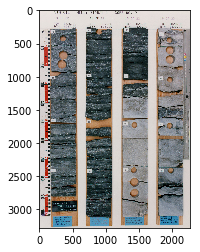

In [12]:
i0 = io.imread(images[0])

plt.imshow(i0)

(41, 2)


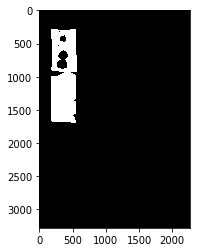

In [21]:
mask = np.zeros((i0.shape[0], i0.shape[1]))

poly1 = np.array(a0['shapes'][0]['points'])
print(poly1.shape)

rr, cc = draw.polygon(poly1[:,1], poly1[:,0])

mask[rr,cc] = 1

plt.imshow(mask, cmap='gray')

In [25]:
sorted(data_dir.glob('*.json'))

[PosixPath('../../include/data/StatOil_jpg/2049_01_1574-1576m.json'),
 PosixPath('../../include/data/StatOil_jpg/2049_02_1814-1818m.json'),
 PosixPath('../../include/data/StatOil_jpg/2049_05_1826-1830m.json'),
 PosixPath('../../include/data/StatOil_jpg/2049_07_1834-1836m.json')]

In [29]:
list(annotations[0].parent.glob(annotations[0].stem + '*.jp*g'))

[PosixPath('../../include/data/StatOil_jpg/2049_05_1826-1830m.jpg')]

In [30]:
annotations[0].stem

'2049_05_1826-1830m'

In [31]:
l = []
l[0]

IndexError: list index out of range

In [13]:
np.zeros((5,3), dtype=np.bool)

array([[False, False, False],
       [False, False, False],
       [False, False, False],
       [False, False, False],
       [False, False, False]])

In [16]:
classes = ['col', 'box', 'scale']

check = ['box1'.startswith(c) for c in classes]
check

[False, True, False]

In [17]:
any(check)

True

In [18]:
sum(check)

1

In [19]:
check.index(True)

1

In [32]:
"""
Dataset class for COCO format segmentation labels
"""
import os
import glob
import numpy as np
import skimage

from mrcnn.utils import Dataset
from mrcnn.config import Config
import mrcnn.model as modellib



DEFAULT_CLASSES = ['col', 'box', 'scale']





class PolygonDataset(Dataset):

    def __init__(self, classes=DEFAULT_CLASSES):

        super().__init__()

        for i, cls_name in zip(range(len(classes)), classes):
            # `source` doesn't matter for us, just saying 'cb' for 'corebreakout'
            self.add_class('cb', i+1, cls_name)     # Note: 'BG' = class 0


    def collect_annotated_images(self, data_dir, subset):
        """
        Check for annotation ('.json') and image ('.jpg'/'.jpeg') pairs,
        and add them all to the dataset. Must be at least one pair in `data_dir`/`subset`.
        """
        data_dir = Path(data_dir) / subset
        assert data_dir.is_dir(), f'Directory {data_dir} must exist.'

        annotations = sorted(data_dir.glob('*.json'))
        assert len(annotations), 'Must be at least one annotation file in `data_dir`'

        for ann_path in annotations:
            image_matches = list(data_dir.glob(ann_path.stem + '*.jp*g'))
            try:
                img_path = image_matches[0]
            except IndexError:
                raise UserWarning(f'Matching .jpg/.jpeg not found for {ann_path}')

            self.add_image('cb', image_id=ann_path.stem, path=img_path, ann_path=ann_path)


    def load_mask(self, image_id):
        """
        Return the instance `mask` and `class_ids` arrays for a given `image_id`.
        """
        ann_path = self.image_info[image_id]['ann_path']

        with open(ann_path, 'r') as ann_file:
            ann_json = json.load(ann_file)

        return self.ann_to_mask(ann_json)


    def ann_to_mask(self, ann):
        """
        Take an annotation dict, return `(mask, class_ids)` arrays.
        Assumes that some classes may have multiple labels (e.g., 'col1', 'col2', ...),
        and that each label may include multiple polygons.
        """
        h, w = ann['imageHeight'], ann['imageWidth']

        unique_labels = list(set([s['label'] for s in ann['shapes']]))

        masks = np.zeros((h, w, len(unique_labels)), dtype=np.bool)

        class_ids = np.array([self.label_to_class_id(l) for l in unique_labels])

        for polygon in ann['shapes']:
            channel = unique_labels.index(polygon['label'])
            coords = np.array(polygon['points'])
            rr, cc = skimage.draw.polygon(coords[:,1], coords[:,0])
            masks[rr,cc,channel] = True

        return masks, class_ids


    def label_to_class_id(self, label):
        """
        Return `class_id` corresponding to `label` given that `label` just needs to start with the class name.
        """
        matches = [label.startswith(c['name']) for c in self.class_info]

        assert any(matches), f'Label {label} must match a class from classes: {self.class_info}'
        assert sum(matches) == 1, f'Label {label} cant match multiple classes in {self.class_info}'

        return self.class_info[matches.index(True)]['id']



    def image_reference(self, image_id):
        """
        Return the path of the image corresponding to `image_id`, if there is one.
        """
        if self.image_info[image_id]['source'] == 'cb':
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

In [33]:
pdset = PolygonDataset()

In [34]:
pdset.collect_annotated_images('../../include/data', 'StatOil_jpg')

In [35]:
img = io.imread(pdset.image_info[0]['path'])
mask = pdset.load_mask(0)

In [37]:
img.shape, mask[0].shape

((3197, 1768, 3), (3197, 1768, 8))

In [38]:
mask_regions = np.zeros((img.shape[0], img.shape[1]))

for i in range(mask[0].shape[-1]):
    mask_regions[np.where(mask[0][...,i])] = mask[1][i]

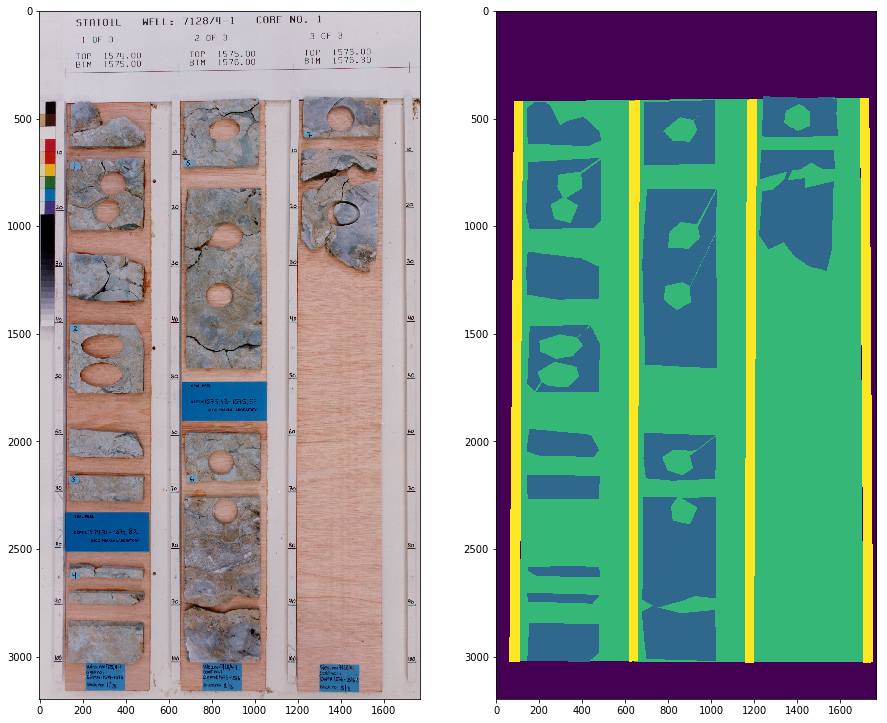

In [40]:
fig, ax = plt.subplots(ncols=2, figsize=(15,15))

ax[0].imshow(img)
ax[1].imshow(mask_regions)